<a href="https://colab.research.google.com/github/sanatsingh/MLP/blob/master/MNIST_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Digit Classification using MLP on MNIST dataset**


In [0]:
#importing libraries
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from collections import OrderedDict
import seaborn as sns

## Loading Data
 Data split in :

*   Training set
*   Validation set 
*   Test set






In [2]:
trf = transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                         ])
traindataset = datasets.MNIST('~/Mnist_data/', download=True, train=True, transform=trf)

testdataset = datasets.MNIST('~/Mnist_data/', download=True, train=False, transform=trf)


Processing...
Done!


In [0]:
valid_size=0.2

n_train=len(traindataset)
indices = list(range(n_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*n_train)) #No of train sets

train_ind , valid_ind = indices[split:] , indices[:split] #Spliting of indices

trainsampler = SubsetRandomSampler(train_ind)
validsampler = SubsetRandomSampler(valid_ind)

trainloader = torch.utils.data.DataLoader(traindataset, batch_size=40, sampler=trainsampler)
validloader = torch.utils.data.DataLoader(traindataset, batch_size=40, sampler=validsampler)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=40)

## Visualizing Data

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def disp(x):
    x = x / 2 + 0.5 #unnormalizing image
    plt.imshow(x.numpy().squeeze(), cmap='Greys_r')

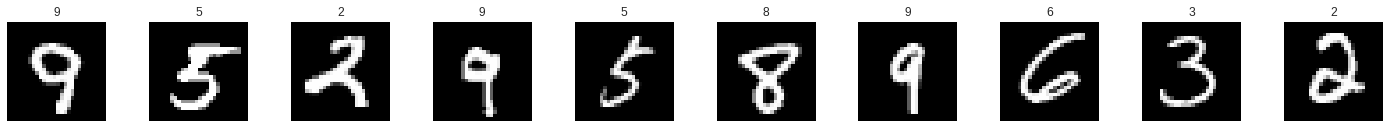

In [0]:
images , labels = next(iter(trainloader))

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    disp(images[idx])
    ax.set_title(int(labels[idx]))

## Defining  Model, Criterion and Optimizers

In [0]:
#Dropout = 0.2, 1 input layer, 2 hidden layers with ReLU as activation function
class MLP_net(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.output = nn.Linear(128,10)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.20)
    
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = self.dropout(self.act(self.fc1(x)))
        x = self.dropout(self.act(self.fc2(x)))
        x = self.output(x)
        return x

model = MLP_net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
epochs = 80

## Training the model

In [0]:
# trgpu = torch.cuda.is_available()

# if not trgpu:
#     print('CUDA is not available')
# else:
#     print('CUDA is available! Training on GPU ...')

In [0]:
model.cuda()

v_loss_min = np.Inf

train_losses, valid_losses = [], []

for i in range(1, epochs+1):
    
    train_loss=0.0
    valid_loss=0.0
    
    model.train()
    for data,target in trainloader:
        data,target = data.cuda(),target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    for v_data,v_target in validloader:
        v_data,v_target = v_data.cuda(),v_target.cuda()
        v_output  = model(v_data)
        v_loss = criterion(v_output,v_target)
        valid_loss += v_loss.item()
        
    train_loss = train_loss/len(trainloader)
    valid_loss = valid_loss/len(validloader)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'Epoch:{i}/{epochs} || Train Loss:{train_loss} || Valid Loss:{valid_loss}')
    
    if valid_loss <= v_loss_min :
        print(f'Validation Loss decreased {v_loss_min} ==> {valid_loss} , Saving Model....')
        torch.save(model.state_dict(), 'model_mnist.pt')
        v_loss_min = valid_loss

Epoch:1/80 || Train Loss:0.4111138063793381 || Valid Loss:0.20998655223598084
Validation Loss decreased inf ==> 0.20998655223598084 , Saving Model....
Epoch:2/80 || Train Loss:0.22306903617689386 || Valid Loss:0.1618185922068854
Validation Loss decreased 0.20998655223598084 ==> 0.1618185922068854 , Saving Model....
Epoch:3/80 || Train Loss:0.18103760819959766 || Valid Loss:0.13061207154455284
Validation Loss decreased 0.1618185922068854 ==> 0.13061207154455284 , Saving Model....
Epoch:4/80 || Train Loss:0.1601353406944933 || Valid Loss:0.1367296986406048
Epoch:5/80 || Train Loss:0.14335690754077707 || Valid Loss:0.1230691708686451
Validation Loss decreased 0.13061207154455284 ==> 0.1230691708686451 , Saving Model....
Epoch:6/80 || Train Loss:0.13312224346833926 || Valid Loss:0.11255059392889961
Validation Loss decreased 0.1230691708686451 ==> 0.11255059392889961 , Saving Model....
Epoch:7/80 || Train Loss:0.12429950761143119 || Valid Loss:0.10999821241246537
Validation Loss decreased 0

## Visualizing the Train Loss and Validation Loss

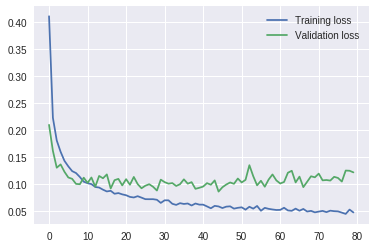

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

## Loading the model with lowest validation loss

In [0]:
model.load_state_dict(torch.load('model_mnist.pt'))

## Testing the model 

In [0]:
model.cuda()
model.eval()

y_pred , y_act = [] ,[]

for idx,(data,target) in enumerate(testloader):
    data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output,target)
    _, pred = torch.max(output, 1)
    y_pred.extend(pred.cpu().numpy())
    y_act.extend(target.cpu().numpy())

    

## Classification Report

### Confusion Matrix

ConfusionMatrix is used to compare the data predicted versus the actual output. It is a matrix in the form: 

![alt text](https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png)

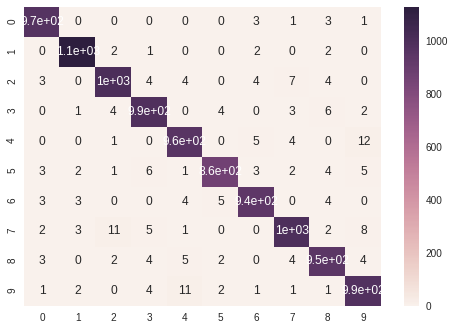

In [10]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_act,y_pred)
import pandas as pd
cm = pd.DataFrame(cm)

sns.heatmap(cm,annot=True)
        

In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_act, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.98      0.97       974
           9       0.97      0.98      0.97      1009

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

